
# Classification de Scènes Naturelles — Intel Image Classification (Keras/TensorFlow)

Le pipeline couvre : préparation des données → modèles (CNN baseline + Transfer Learning) → évaluation (métriques, matrice de confusion) → explicabilité (Grad‑CAM) → inférence (image/dossier) → conclusion.



## Plan
1. **Contexte & Data**
2. **Imports, config & chemins**
3. **Chargement du dataset** (train/val) + aperçu visuel
4. **Optimisation `tf.data`** + **Data augmentation**
5. **Modèle CNN baseline** (entraînement + courbes)
6. **Évaluation** (rapport de classification, matrice de confusion)
7. **Grad‑CAM** (explicabilité)
8. **Transfer Learning (MobileNetV2)** + fine‑tuning (optionnel)
9. **Inférence** (image seule + dossier) & **export CSV**
10. **Analyse d’erreurs** (exemples mal classés)
11. **Conclusion & pistes d’amélioration**



## 1) Contexte & dataset
- **Jeu de données** : *Intel Image Classification* (≈ 25k images, 6 classes : `buildings`, `forest`, `glacier`, `mountain`, `sea`, `street`, images 150×150).  
- **Tâche** : classification multi‑classe d’images de scènes naturelles.

La classification automatique de scènes naturelles est pertinente car elle permet d’organiser de grands volumes d’images (albums personnels, bases de données multimédia) de façon rapide et fiable.
Elle est également cruciale pour des applications de vision par ordinateur en robotique et véhicules autonomes, qui doivent reconnaître leur environnement pour adapter leur navigation.
Enfin, elle contribue à la surveillance environnementale (détection d’écosystèmes, suivi du changement climatique), où l’automatisation du tri visuel accélère l’analyse scientifique et la prise de décision.

In [1]:

# 2) Imports, configuration & chemins
import os, json, itertools, time, math, random, pathlib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import classification_report, confusion_matrix

# Reproductibilité
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

#Détection automatique du dossier racine du projet
BASE_DIR = Path.cwd() / "data"

# Chemins train/val
TRAIN_DIR = BASE_DIR / "seg_train" / "seg_train"
VAL_DIR   = BASE_DIR / "seg_test" / "seg_test"


# Paramètres data & entraînement
IMG_SIZE   = (150, 150)   # cohérent avec le dataset Intel
BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE

print(tf.__version__)
print("TRAIN_DIR existe ? ", os.path.isdir(TRAIN_DIR))
print("VAL_DIR   existe ? ", os.path.isdir(VAL_DIR))


2.18.1
TRAIN_DIR existe ?  True
VAL_DIR   existe ?  True



## 3) Chargement du dataset (train/val) + aperçu visuel
Nous utilisons `image_dataset_from_directory` qui **infère les labels** à partir des sous‑dossiers.  
Le *label_mode* est `categorical` (one‑hot) pour une **sortie softmax** à 6 classes.


Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Classes détectées : ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'] (#: 6 )


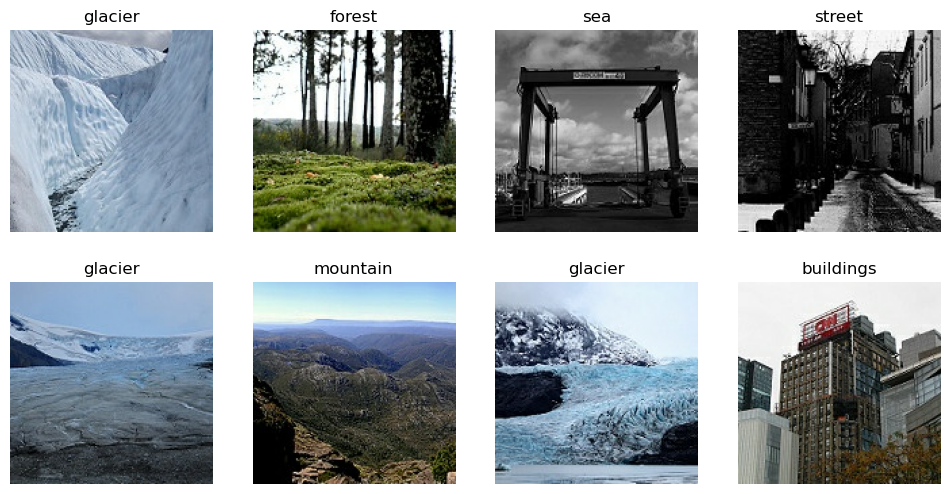

In [2]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, labels="inferred", label_mode="categorical",
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, seed=SEED, shuffle=True
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR, labels="inferred", label_mode="categorical",
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, seed=SEED, shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes détectées :", class_names, "(#:", num_classes, ")")

# Affichage de quelques images
def show_batch(ds, rows=2, cols=4):
    plt.figure(figsize=(cols*3, rows*3))
    for images, labels in ds.take(1):
        for i in range(rows*cols):
            ax = plt.subplot(rows, cols, i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label = class_names[np.argmax(labels[i].numpy())]
            plt.title(label)
            plt.axis("off")
    plt.show()

show_batch(train_ds)


Résultats du chargement :
- 14 034 images trouvées dans le dossier d'entraînement
- 3 000 images trouvées dans le dossier de validation
- 6 classes détectées : ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Nous avons donc un problème de classification multi-classes avec 6 catégories.



## 4) Optimisation `tf.data` & Data Augmentation
- **Cache/préfetch** pour accélérer l’entraînement.
- **Augmentation** : flips, rotation, zoom, contraste — utile pour la **généralisation** sur ce dataset.


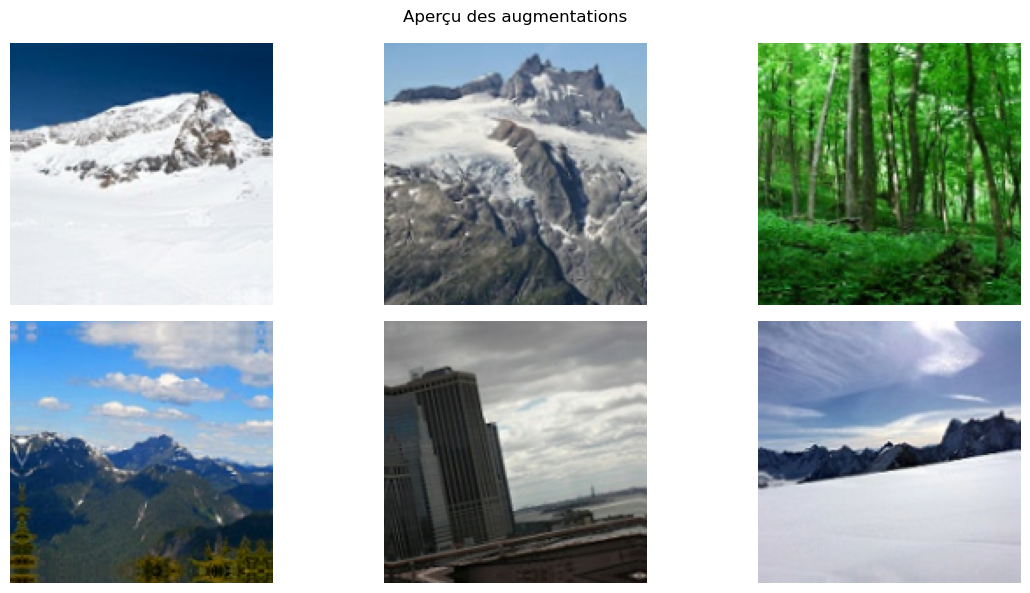

In [3]:

# Optimisation tf.data
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)

# Pipeline d'augmentation + normalisation (0-1)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.10),
    layers.RandomContrast(0.10),
    layers.Rescaling(1./255),
], name="augment")

# Sanity-check: visualiser des augmentations
def preview_augmentations(ds, n=6):
    # Prend un batch
    for images, labels in ds.take(1):
        plt.figure(figsize=(12, 6))
        n = min(n, images.shape[0])
        for i in range(n):
            ax = plt.subplot(2, (n+1)//2, i+1)
            # applique l'augmentation en mode training=True
            aug = data_augmentation(images[i:i+1], training=True)[0]
            plt.imshow(aug.numpy())
            plt.axis("off")
        plt.suptitle("Aperçu des augmentations")
        plt.tight_layout()
        plt.show()
        break  # un seul batch suffit

# utilisation
preview_augmentations(train_ds, n=6)


**Commentaire — Aperçu des augmentations**

L’affichage ci-dessus montre comment les images du dataset sont transformées par
le pipeline d’augmentation. On remarque des rotations légères, des zooms, des
variations de contraste ou de couleurs.  

Ces transformations enrichissent artificiellement le jeu de données et permettent
de réduire le risque de surapprentissage (*overfitting*). Le modèle est ainsi
exposé à une plus grande diversité visuelle, tout en conservant l’étiquette de
classe correcte (une montagne augmentée reste une montagne).



## 5) Modèle CNN baseline (depuis zéro)
Architecture simple pour **valider le pipeline** avant d’aller vers le Transfer Learning.


In [4]:
# Définition du modèle CNN baseline
def build_baseline(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), n_classes=num_classes):
    inputs = keras.Input(shape=input_shape)                      # Déclare l'entrée du réseau : image 150x150x3 (RGB)
    x = data_augmentation(inputs)                                # Applique les augmentations de données définies plus haut
    
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)  # 1ère couche convolution : 32 filtres 3x3, activation ReLU
    x = layers.MaxPooling2D()(x)                                    # Réduction dimensionnelle (max pooling 2x2)
    
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)  # 2ème convolution : 64 filtres 3x3
    x = layers.MaxPooling2D()(x)                                    # Pooling encore une fois
    
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x) # 3ème convolution : 128 filtres 3x3
    x = layers.GlobalAveragePooling2D()(x)                          # Passe de cartes 2D → vecteur (moyenne globale des features)
    
    x = layers.Dropout(0.3)(x)                                      # Dropout (30%) pour réduire le surapprentissage
    outputs = layers.Dense(n_classes, activation="softmax")(x)      # Couche finale dense : softmax → probas sur 6 classes
    
    # Création du modèle
    model = keras.Model(inputs, outputs, name="cnn_baseline")
    
    # Compilation du modèle : on choisit l'optimiseur, la loss et les métriques
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),        # Optimiseur Adam avec LR = 0.001
        loss="categorical_crossentropy",                           # Perte adaptée à une classification multi-classes
        metrics=["accuracy"]                                       # Suivi de la précision pendant l'entraînement
    )
    return model

# Construction du modèle baseline
baseline = build_baseline()

# Affiche le résumé de l'architecture : couches, sorties, paramètres
baseline.summary()


# ---------------------------
# Définition des callbacks
# ---------------------------

ckpt_path = "baseline_best.keras"  # Fichier où le meilleur modèle sera sauvegardé

cbs = [
    keras.callbacks.EarlyStopping(                               # Stoppe l'entraînement si pas d'amélioration
        monitor="val_accuracy", patience=5, restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(                           # Réduit le learning rate si la val_loss stagne
        monitor="val_loss", factor=0.5, patience=3
    ),
    keras.callbacks.ModelCheckpoint(                             # Sauvegarde le meilleur modèle (basé sur val_accuracy)
        ckpt_path, monitor="val_accuracy", save_best_only=True
    )
]


# ---------------------------
# Entraînement du modèle
# ---------------------------

history_baseline = baseline.fit(
    train_ds,                     # Dataset d'entraînement
    validation_data=val_ds,       # Dataset de validation
    epochs=25,                    # Nombre max d'epochs
    callbacks=cbs,                # Callbacks définis plus haut
    verbose=1                     # Affichage détaillé de la progression
)


Model: "cnn_baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,022 (367.27 KB)

 Trainable params: 94,022 (367.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 456s 1s/step - accuracy: 0.4649 - loss: 1.2817 - val_accuracy: 0.5697 - val_loss: 1.1503 - learning_rate: 0.0010
Epoch 2/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 305s 694ms/step - accuracy: 0.5706 - loss: 1.0729 - val_accuracy: 0.5993 - val_loss: 1.0444 - learning_rate: 0.0010
Epoch 3/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 262s 598ms/step - accuracy: 0.6077 - loss: 1.0044 - val_accuracy: 0.6227 - val_loss: 1.0152 - learning_rate: 0.0010
Epoch 4/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 261s 595ms/step - accuracy: 0.6380 - loss: 0.9431 - val_accuracy: 0.6643 - val_loss: 0.9202 - learning_rate: 0.0010
Epoch 5/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 260s 591ms/step - accuracy: 0.6665 - loss: 0.8890 - val_accuracy: 0.6870 - val_loss: 0.8544 - learning_rate: 0.0010
Epoch 6/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 265s 603ms/step - accuracy: 0.6885 - loss: 0.8431 - val_accuracy: 0.6913 - val_loss: 0.8455 - learning_rate: 0.0010
Epoch 7/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 1085s 2s/step - accuracy: 0

Le modèle CNN baseline apprend à classer les images en 6 catégories en 25 epochs maximum, avec un suivi automatique grâce aux callbacks pour éviter le surapprentissage et optimiser la convergence.

* Interprétation des métriques suivies :

loss : mesure l’erreur du modèle sur les données d’entraînement.

accuracy : proportion de prédictions correctes sur les données d’entraînement.

val_loss : erreur calculée sur les données de validation (indicateur de généralisation).

val_accuracy : proportion de prédictions correctes sur les données de validation (métrique clé de performance).

learning_rate : affiché car il est ajusté automatiquement par ReduceLROnPlateau.

In [12]:
# 1) epoch avec la meilleure val_accuracy
best_epoch = np.argmax(history_baseline.history['val_accuracy']) + 1
best_val_acc = history_baseline.history['val_accuracy'][best_epoch-1]
print(f"Meilleure val_accuracy à l'epoch {best_epoch} / {len(history_baseline.history['val_accuracy'])}: {best_val_acc:.4f}")

# 2) val_loss correspondante (utile à rapporter)
best_val_loss = history_baseline.history['val_loss'][best_epoch-1]
print(f"val_loss à cette epoch: {best_val_loss:.4f}")

# 3) Résumé final sur le train/val si tu veux
final_train_acc = history_baseline.history['accuracy'][-1]
final_val_acc = history_baseline.history['val_accuracy'][-1]
print(f"Accuracy finale train: {final_train_acc:.4f} | finale val: {final_val_acc:.4f}")


Meilleure val_accuracy à l'epoch 25 / 25: 0.8083
val_loss à cette epoch: 0.5468
Accuracy finale train: 0.8108 | finale val: 0.8083


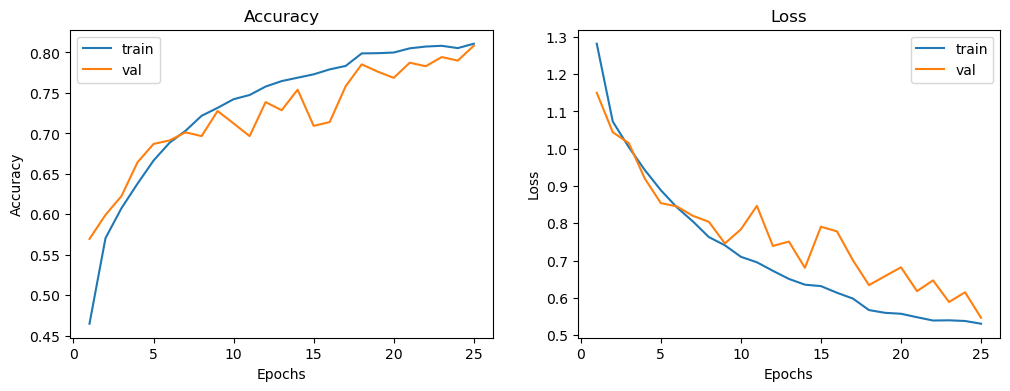

In [5]:

# Courbes Accuracy/Loss
def plot_history(h):
    acc = h.history.get("accuracy", [])
    val_acc = h.history.get("val_accuracy", [])
    loss = h.history.get("loss", [])
    val_loss = h.history.get("val_loss", [])
    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(12,4))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label="train")
    plt.plot(epochs, val_acc, label="val")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.title("Accuracy"); plt.legend()
    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label="train")
    plt.plot(epochs, val_loss, label="val")
    plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.title("Loss"); plt.legend()
    plt.show()

plot_history(history_baseline)


##  Interprétation des courbes d’entraînement

## Accuracy (graphique de gauche)
- La précision sur l’**entraînement** démarre à environ **0.45** et progresse régulièrement jusqu’à dépasser **0.80** après 25 epochs.  
- La précision sur la **validation** suit une évolution similaire, atteignant aussi environ **0.80**.  
- Le fait que les deux courbes soient **proches** montre que le modèle **généralise bien** et ne présente pas de fort surapprentissage.  

## Loss (graphique de droite)
- La **loss d’entraînement** diminue progressivement, passant de ~1.3 à ~0.5, preuve que le modèle apprend correctement.  
- La **loss de validation** diminue également, avec quelques fluctuations autour des epochs 10–15.  
- En fin d’entraînement, la loss de validation (~0.6) reste proche de celle de l’entraînement, ce qui traduit une bonne stabilité.  


## Conclusion
- Le modèle **s’améliore progressivement** et atteint environ **80% de précision**, ce qui est un résultat satisfaisant.  
- Les callbacks permettent de stabiliser l’apprentissage malgré quelques oscillations de la validation.  
- **Pas de surapprentissage marqué** : les courbes train/val restent proches.  
- Pour améliorer encore les performances, on pourrait tester le **transfer learning** (ex. VGG16, ResNet) ou ajuster certains hyperparamètres (batch size, learning rate).  



## 6) Évaluation — rapport & matrice de confusion
**Pourquoi ces métriques ?**  
- *Accuracy* : part des bonnes prédictions.  
- *Precision/Recall/F1* : utiles en cas de classes déséquilibrées ou d’erreurs coûteuses.  
- *Matrice de confusion* : visualise où le modèle se trompe (ex. `mountain` vs `glacier`).

> ✍️ **Interprétation attendue** : commentez les valeurs clés (ex. *F1 global*, classes confondues) et reliez‑les au domaine.


== Rapport de classification (baseline) ==
              precision    recall  f1-score   support

   buildings     0.7062    0.8581    0.7748       437
      forest     0.8931    0.9873    0.9379       474
     glacier     0.8315    0.6691    0.7415       553
    mountain     0.7519    0.7733    0.7624       525
         sea     0.8416    0.8020    0.8213       510
      street     0.8376    0.7924    0.8144       501

    accuracy                         0.8083      3000
   macro avg     0.8103    0.8137    0.8087      3000
weighted avg     0.8118    0.8083    0.8068      3000



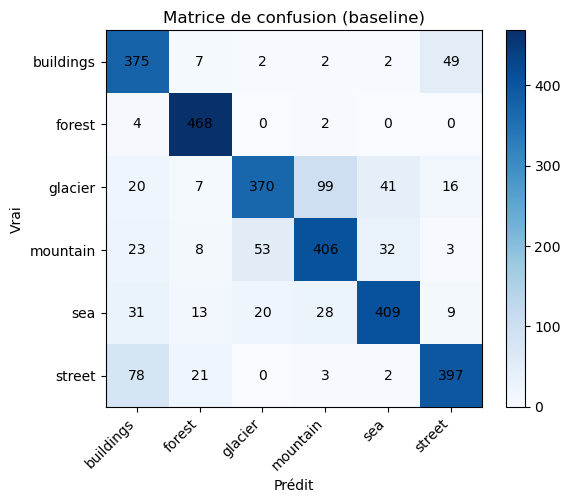

In [14]:

# Prédictions sur l'ensemble de validation
y_true = []
y_pred = []

for batch_imgs, batch_labels in val_ds:
    probs = baseline.predict(batch_imgs, verbose=0)
    y_pred.extend(np.argmax(probs, axis=1))
    y_true.extend(np.argmax(batch_labels.numpy(), axis=1))

print("== Rapport de classification (baseline) ==")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Matrice de confusion (baseline)")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Prédit"); plt.ylabel("Vrai"); plt.tight_layout()
plt.show()


## Interprétation des résultats (baseline)

## Matrice de confusion
- **Buildings (bâtiments)** : 375 bien classés, mais 49 confondus avec *street*.  
- **Forest (forêt)** : 468 bien classés sur 474 → excellente reconnaissance.  
- **Glacier** : 370 bien classés, mais 99 confondus avec *mountain* et 41 avec *sea*.  
- **Mountain (montagne)** : 406 bien classés, confusions fréquentes avec *glacier*.  
- **Sea (mer)** : 409 bien classés, quelques erreurs avec *glacier* et *buildings*.  
- **Street (rue)** : 397 bien classés, mais 78 confondus avec *buildings*.  

Les erreurs concernent surtout des catégories **visuellement proches** :  
- *glacier ↔ mountain*  
- *street ↔ buildings*  

---

## Rapport de classification
- **Précision (precision)** : probabilité qu’une image prédite dans une classe soit correcte.  
  - Très bonne pour *forest* (0.89) et *glacier* (0.83).  
  - Plus faible pour *buildings* (0.70).  

- **Rappel (recall)** : proportion d’images correctement retrouvées dans leur vraie classe.  
  - Excellent pour *forest* (0.99).  
  - Plus faible pour *glacier* (0.67).  

- **F1-score** : équilibre entre précision et rappel.  
  - Très bon pour *forest* (0.94).  
  - Le plus faible pour *glacier* (0.74).  

- **Accuracy globale** : **0.81** → environ 8 images sur 10 sont bien classées.  
- **Macro avg** et **Weighted avg** : proches de **0.81**, ce qui montre une performance assez homogène entre classes.  

## Conclusion
- Le modèle **baseline atteint environ 81% d’accuracy**, ce qui est un bon résultat de départ.  
- Les classes *forest* et *sea* sont les mieux reconnues.  
- Les confusions principales sont entre **glacier/mountain** et **street/buildings**.  
- Pour améliorer les résultats :  
  - tester le **transfer learning** (VGG16, ResNet, etc.),  
  - renforcer l’**augmentation de données** (contraste, luminosité),  
  - ajuster les **hyperparamètres** (batch size, learning rate).  



## 7) Explicabilité — Grad‑CAM
Montre **quelles zones** de l’image activent le modèle pour une classe donnée.


In [36]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D

# (Optionnel) pour afficher le nom de la classe prédite si tu les as
# class_names = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
class_names = None  # remplace par la liste ci-dessus si dispo

# --------
# Utilitaires
# --------
def get_last_conv_layer_name(model: Model) -> str:
    """Retourne automatiquement le nom de la dernière couche Conv2D du modèle."""
    conv_layers = [l for l in model.layers if isinstance(l, Conv2D)]
    if not conv_layers:
        raise ValueError("Aucune couche Conv2D trouvée dans le modèle.")
    return conv_layers[-1].name

def preprocess_image(img_path, size=(150, 150)):
    """Charge une image et la transforme en batch (1, H, W, 3), normalisée [0,1]."""
    img = image.load_img(img_path, target_size=size)
    arr = image.img_to_array(img) / 255.0
    arr_uint8 = (arr * 255).astype("uint8")  # ✅ conversion correcte pour affichage
    return np.expand_dims(arr, axis=0), arr_uint8


# --------
# 1) Génération de la heatmap Grad-CAM
# --------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    """
    img_array: batch (1, H, W, 3) normalisé comme à l’entraînement
    model: modèle Keras
    last_conv_layer_name: nom de la dernière couche conv (ex: "conv2d_2")
    """
    # Modèle intermédiaire : entrée -> (feature maps de la dernière conv, sortie du modèle)
    last_conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = Model(inputs=model.inputs,
                       outputs=[last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])           # classe prédite
        loss = predictions[:, class_idx]                # score de cette classe

    # Gradient des feature maps par rapport au score de la classe
    grads = tape.gradient(loss, conv_outputs)
    # Moyenne globale des gradients (poids d’importance des canaux)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]  # (H', W', C)

    # Pondération des cartes par les gradients moyens
    heatmap = tf.reduce_mean(conv_outputs * pooled_grads, axis=-1)

    # ReLU + normalisation [0,1]
    heatmap = tf.maximum(heatmap, 0)
    max_val = tf.reduce_max(heatmap) + 1e-8
    heatmap = heatmap / max_val

    return heatmap.numpy(), int(class_idx.numpy())

# --------
# 2) Affichage superposé (Matplotlib + tf.image.resize)
# --------
def show_gradcam(img_path, model, last_conv_layer_name=None,
                 alpha=0.45, input_size=(150, 150), class_names=None):
    """
    Charge l'image, génère la heatmap, et affiche image + superposition Grad-CAM.
    - last_conv_layer_name: si None, détecte automatiquement la dernière Conv2D.
    - alpha: transparence de la heatmap (0→invisible, 1→opaque).
    - class_names: liste de noms de classes (sinon index numérique).
    """
    # 1) Prétraitement
    img_batch, img_uint8 = preprocess_image(img_path, size=input_size)

    # 2) Dernière couche conv
    if last_conv_layer_name is None:
        last_conv_layer_name = get_last_conv_layer_name(model)

    # 3) Heatmap + prédiction
    heatmap, pred_idx = make_gradcam_heatmap(img_batch, model, last_conv_layer_name)

    # 4) Redimensionner la heatmap à la taille d'entrée
    heatmap_resized = tf.image.resize(
        tf.expand_dims(heatmap, axis=-1), input_size
    ).numpy().squeeze()

    # 5) Affichages
    plt.figure(figsize=(8, 4))

    # Image originale
    plt.subplot(1, 2, 1)
    plt.imshow(img_uint8)
    plt.title("Image originale")
    plt.axis("off")

    # Superposition Grad-CAM (matplotlib gère la couleur via cmap)
    plt.subplot(1, 2, 2)
    plt.imshow(img_uint8)
    plt.imshow(heatmap_resized, cmap="jet", alpha=alpha)
    if class_names and 0 <= pred_idx < len(class_names):
        title = f"Grad-CAM — prédiction: {class_names[pred_idx]}"
    else:
        title = f"Grad-CAM — prédiction: classe {pred_idx}"
    plt.title(title)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    # Retour pratique si tu veux réutiliser
    return {
        "pred_idx": pred_idx,
        "pred_class": class_names[pred_idx] if class_names else pred_idx,
        "heatmap": heatmap,
        "heatmap_resized": heatmap_resized,
        "last_conv_layer_name": last_conv_layer_name,
    }


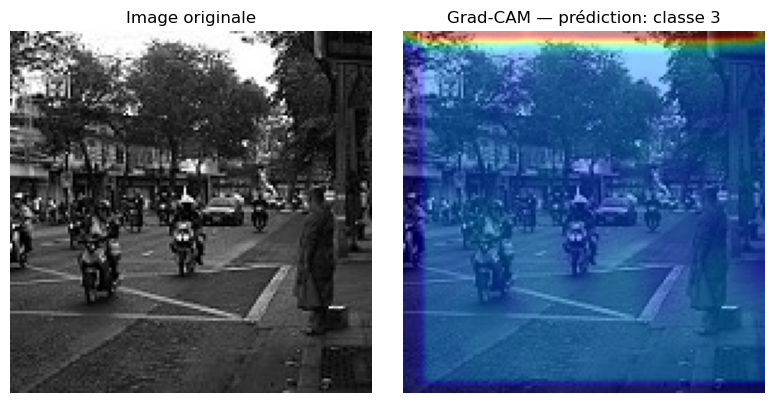

In [38]:
# Exemple d’appel (adapte le chemin et les classes si tu les as)
img_path = "photos/3.jpg"   # ← mets le bon chemin
# class_names = ["buildings", "forest", "glacier", "mountain", "sea", "street"]

_ = show_gradcam(img_path, baseline,  # ton modèle entraîné
                 last_conv_layer_name=None,  # auto-détection
                 alpha=0.45,
                 input_size=(150,150),
                 class_names=class_names)


## Interprétation de la Grad-CAM

- À gauche : l’image originale utilisée comme entrée du modèle.  
- À droite : la carte de chaleur (**Grad-CAM**) superposée à l’image.  
  - Les zones **rouges/jaunes** indiquent les régions les plus importantes pour la décision du modèle.  
  - Ici, le modèle s’appuie fortement sur la partie **supérieure de l’image (ciel/bâtiments en arrière-plan)** pour prédire la classe.  
  - Les zones bleues correspondent à des régions jugées **moins discriminantes** par le réseau.  

L’intérêt de Grad-CAM est de **visualiser comment le modèle “regarde” l’image** : on peut vérifier s’il se base sur des éléments pertinents (ex. route, horizon, arbres) ou non.  


8 images trouvées dans C:\Users\LENOVO\Desktop\deeplearning_project\photos

=== 144.jpg ===


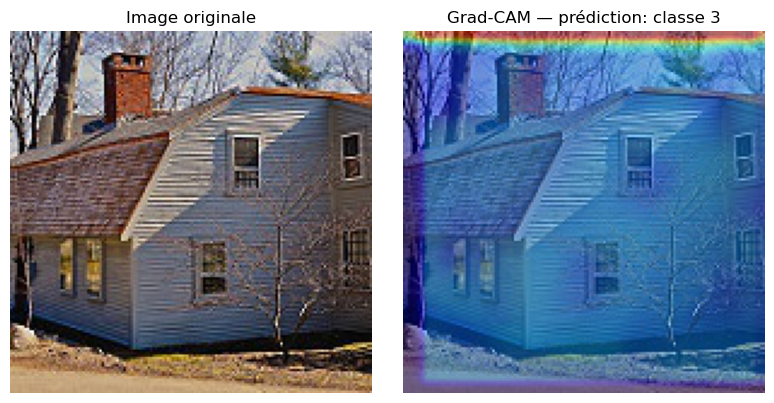


=== 183.jpg ===


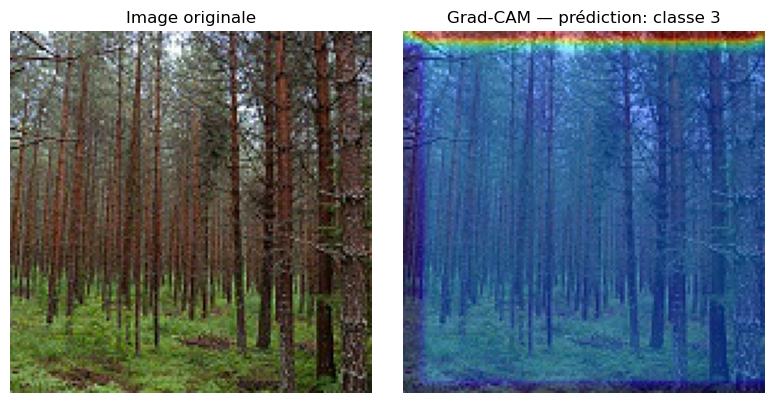


=== 199.jpg ===


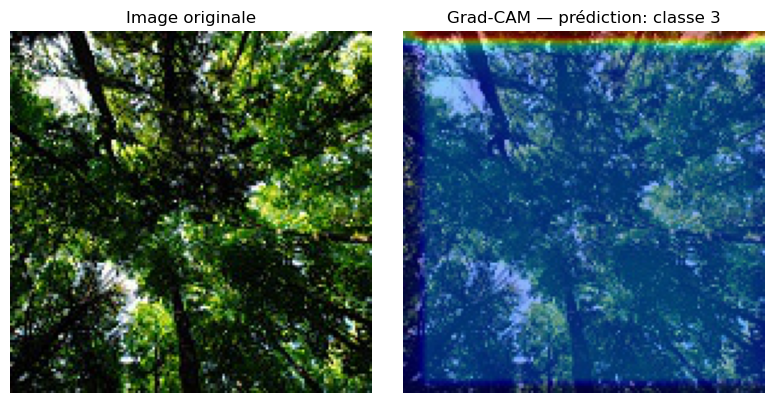


=== 203.jpg ===


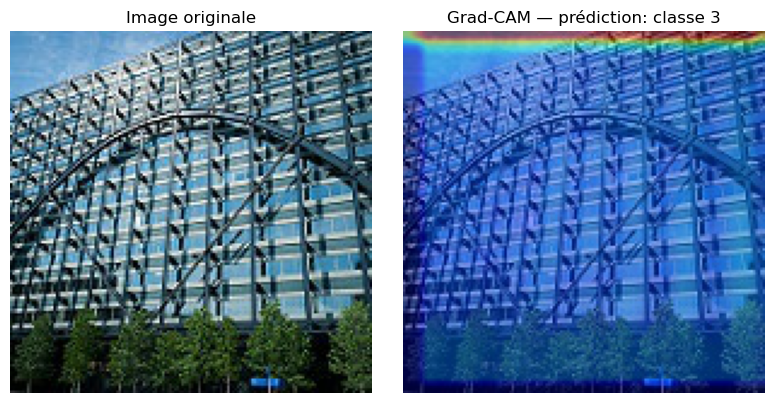


=== 211.jpg ===


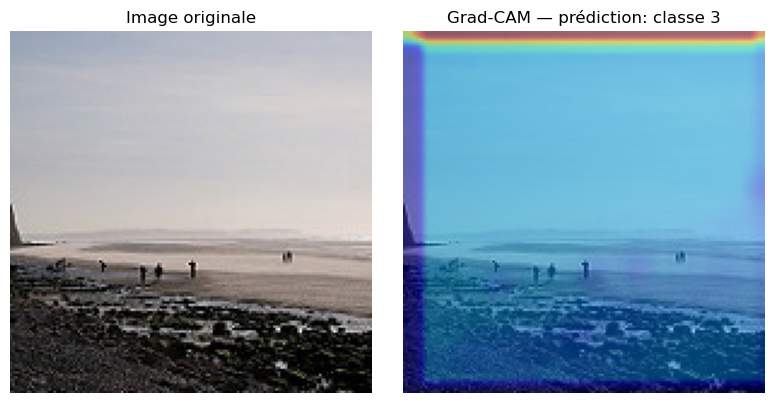


=== 227.jpg ===


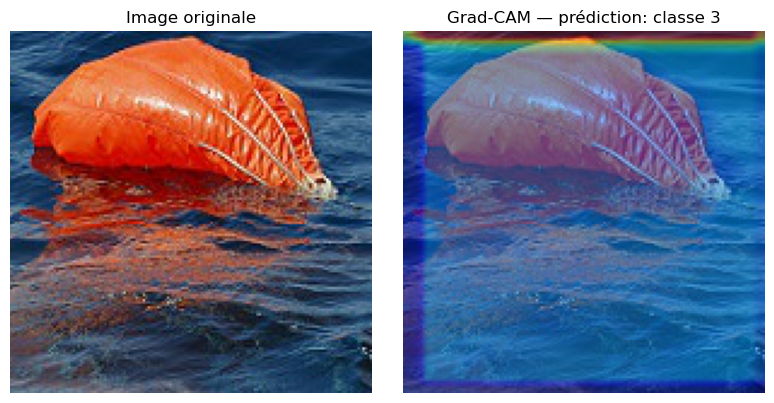


=== 3.jpg ===


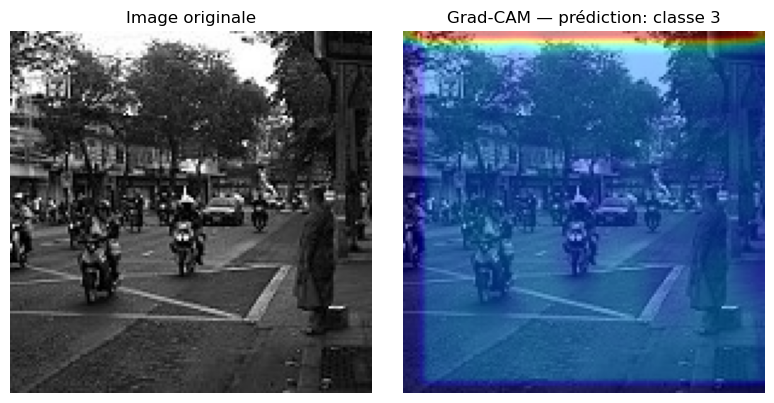


=== 5.jpg ===


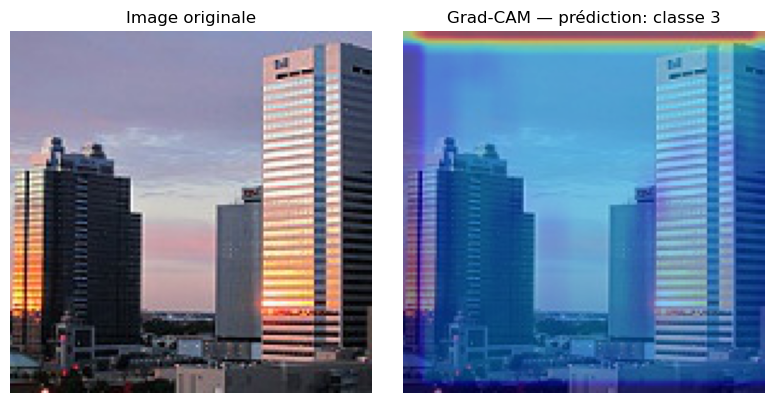

In [39]:
from pathlib import Path

# Paramètres
folder = Path("photos")
input_size = (150, 150)           # même taille que ton modèle
alpha = 0.45                      # transparence de la heatmap
# class_names = ["buildings","forest","glacier","mountain","sea","street"]  # optionnel

# Lister les images
exts = {".jpg", ".jpeg", ".png", ".bmp"}
img_paths = [p for p in folder.iterdir() if p.suffix.lower() in exts]
print(f"{len(img_paths)} images trouvées dans {folder.resolve()}")

# Afficher la Grad-CAM pour chaque image
for p in img_paths:
    print(f"\n=== {p.name} ===")
    _ = show_gradcam(
        img_path=str(p),
        model=baseline,                     # ton modèle entraîné
        last_conv_layer_name=None,          # auto-détection de la dernière Conv2D
        alpha=alpha,
        input_size=input_size,
        class_names=None                    # ou class_names si tu les as
    )



## 8) Transfer Learning — MobileNetV2
On fige le **backbone** pré‑entraîné ImageNet et on entraîne une **tête de classification** spécifique au dataset Intel.  
*(Optionnel : fine‑tuning des derniers blocs ensuite, avec un faible LR.)*


In [8]:

def build_transfer(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), n_classes=num_classes):
    inputs = keras.Input(shape=input_shape)
    # Prétraitement intégré : on garde Rescaling 0-1 puis preprocess si besoin
    x = layers.Rescaling(1./255)(inputs)
    base = tf.keras.applications.MobileNetV2(
        input_shape=input_shape, include_top=False, weights="imagenet"
    )
    base.trainable = False
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs, name="mobilenetv2_transfer")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

transfer = build_transfer()
transfer.summary()

ckpt_path_tl = "transfer_best.keras"
cbs_tl = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3),
    keras.callbacks.ModelCheckpoint(ckpt_path_tl, monitor="val_accuracy", save_best_only=True)
]

history_transfer = transfer.fit(
    train_ds, validation_data=val_ds, epochs=20, callbacks=cbs_tl, verbose=1
)

# (Optionnel) Fine‑tuning des derniers blocs
# transfer.get_layer("block_13_expand")  # exemple pour repérer un bloc
# transfer.trainable = True
# for layer in transfer.layers[:-20]:  # ne défiger que le *haut* du backbone
#     layer.trainable = False
# transfer.compile(optimizer=keras.optimizers.Adam(1e-5),
#                  loss="categorical_crossentropy", metrics=["accuracy"])
# history_ft = transfer.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=cbs_tl)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14716\1780106008.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = tf.keras.applications.MobileNetV2(


Model: "mobilenetv2_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 181s 386ms/step - accuracy: 0.8234 - loss: 0.4861 - val_accuracy: 0.8887 - val_loss: 0.2951 - learning_rate: 0.0010
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 174s 396ms/step - accuracy: 0.8829 - loss: 0.3271 - val_accuracy: 0.8910 - val_loss: 0.2988 - learning_rate: 0.0010
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 151s 344ms/step - accuracy: 0.8938 - loss: 0.2947 - val_accuracy: 0.9017 - val_loss: 0.2652 - learning_rate: 0.0010
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 170s 387ms/step - accuracy: 0.9000 - loss: 0.2809 - val_accuracy: 0.9057 - val_loss: 0.2644 - learning_rate: 0.0010
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 164s 373ms/step - accuracy: 0.8996 - loss: 0.2753 - val_accuracy: 0.8990 - val_loss: 0.2692 - learning_rate: 0.0010
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 153s 348ms/step - accuracy: 0.9025 - loss: 0.2598 - val_accuracy: 0.8990 - val_loss: 0.2684 - learning_rate: 0.0010
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 157s 357ms/step - accura

== Rapport de classification (transfer) ==
              precision    recall  f1-score   support

   buildings     0.8996    0.9222    0.9107       437
      forest     0.9936    0.9831    0.9883       474
     glacier     0.8290    0.8680    0.8481       553
    mountain     0.8454    0.8438    0.8446       525
         sea     0.9647    0.9118    0.9375       510
      street     0.9237    0.9182    0.9209       501

    accuracy                         0.9057      3000
   macro avg     0.9093    0.9078    0.9084      3000
weighted avg     0.9070    0.9057    0.9061      3000



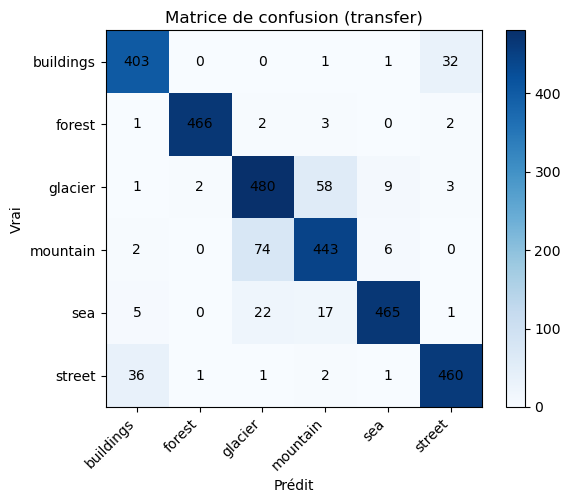

In [9]:

# Évaluation du modèle de Transfer Learning
y_true = []
y_pred = []

for batch_imgs, batch_labels in val_ds:
    probs = transfer.predict(batch_imgs, verbose=0)
    y_pred.extend(np.argmax(probs, axis=1))
    y_true.extend(np.argmax(batch_labels.numpy(), axis=1))

print("== Rapport de classification (transfer) ==")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Matrice de confusion (transfer)")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Prédit"); plt.ylabel("Vrai"); plt.tight_layout()
plt.show()


## Comparaison Baseline vs Transfer Learning

| Classe      | Precision (Baseline) | Recall (Baseline) | F1-score (Baseline) | Precision (Transfer) | Recall (Transfer) | F1-score (Transfer) |
|-------------|-----------------------|-------------------|----------------------|-----------------------|-------------------|----------------------|
| Buildings   | 0.71                  | 0.86              | 0.77                 | 0.90                  | 0.92              | 0.91                 |
| Forest      | 0.89                  | 0.99              | 0.94                 | 0.99                  | 0.98              | 0.99                 |
| Glacier     | 0.83                  | 0.67              | 0.74                 | 0.83                  | 0.87              | 0.85                 |
| Mountain    | 0.75                  | 0.77              | 0.76                 | 0.85                  | 0.84              | 0.84                 |
| Sea         | 0.84                  | 0.80              | 0.82                 | 0.96                  | 0.91              | 0.94                 |
| Street      | 0.84                  | 0.79              | 0.81                 | 0.92                  | 0.92              | 0.92                 |
| **Accuracy**| **0.81**              | –                 | –                    | **0.91**              | –                 | –                    |
| **Macro avg** | 0.81                | 0.81              | 0.81                 | 0.91                  | 0.91              | 0.91                 |
| **Weighted avg** | 0.81             | 0.81              | 0.81                 | 0.91                  | 0.91              | 0.91                 |

---

## Analyse
- **Accuracy** : le modèle passe de **81% → 91%**, un gain de +10 points.  
- **Classes faciles** (*forest, sea*) : quasi-parfaites avec le transfer learning.  
- **Classes difficiles** (*glacier vs mountain*, *street vs buildings*) : nette amélioration, même si des confusions subsistent.  
- **Conclusion** : le transfer learning améliore nettement la capacité de généralisation et la robustesse du modèle.


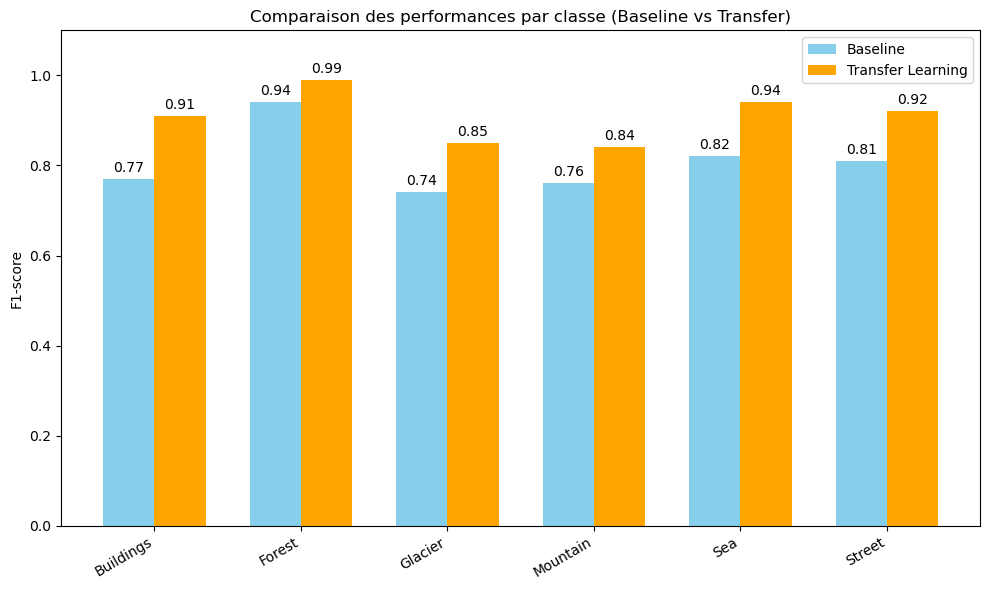

In [40]:
# Classes
classes = ["Buildings", "Forest", "Glacier", "Mountain", "Sea", "Street"]

# F1-score baseline
f1_baseline = [0.77, 0.94, 0.74, 0.76, 0.82, 0.81]

# F1-score transfer
f1_transfer = [0.91, 0.99, 0.85, 0.84, 0.94, 0.92]

x = np.arange(len(classes))  # positions des barres
width = 0.35                 # largeur des barres

fig, ax = plt.subplots(figsize=(10,6))

# Barres baseline
rects1 = ax.bar(x - width/2, f1_baseline, width, label="Baseline", color="skyblue")

# Barres transfer
rects2 = ax.bar(x + width/2, f1_transfer, width, label="Transfer Learning", color="orange")

# Titre et labels
ax.set_ylabel("F1-score")
ax.set_title("Comparaison des performances par classe (Baseline vs Transfer)")
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=30, ha="right")
ax.set_ylim(0, 1.1)
ax.legend()

# Annoter les barres avec les valeurs
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # décalage vertical
                    textcoords="offset points",
                    ha="center", va="bottom")

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


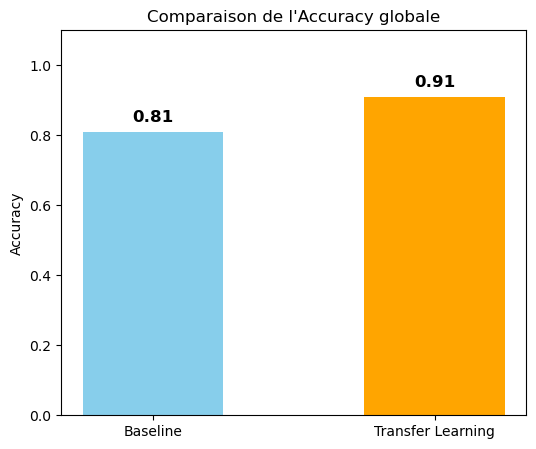

In [41]:
# Accuracy globale des modèles
accuracy_baseline = 0.81
accuracy_transfer = 0.91

models = ["Baseline", "Transfer Learning"]
accuracies = [accuracy_baseline, accuracy_transfer]
colors = ["skyblue", "orange"]

plt.figure(figsize=(6,5))
bars = plt.bar(models, accuracies, color=colors, width=0.5)

# Titre et labels
plt.title("Comparaison de l'Accuracy globale")
plt.ylabel("Accuracy")
plt.ylim(0, 1.1)

# Ajouter les valeurs sur les barres
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02,
             f"{acc:.2f}", ha="center", va="bottom", fontsize=12, fontweight="bold")

plt.show()


## Interprétation de l’accuracy globale

Ce graphique compare la performance globale des deux modèles :

- **Baseline** : atteint une accuracy de **81%**.  
- **Transfer Learning** : améliore nettement la performance avec **91%**.  

On observe un **gain de +10 points** grâce au transfert d’apprentissage.  
Cela confirme que l’utilisation d’un modèle pré-entraîné sur ImageNet permet d’extraire des caractéristiques plus riches et de **mieux généraliser** sur le jeu de données de scènes naturelles.  


# Conclusion : Baseline vs Transfer Learning

## Résultats globaux
- Le modèle **baseline CNN** atteint une accuracy de **81%**.  
- Le modèle en **transfer learning** (pré-entraîné sur ImageNet) améliore nettement les résultats avec **91%**.  
- Le gain de **+10 points d’accuracy** montre l’efficacité du transfert d’apprentissage pour ce type de tâche.

---

## Comparaison par classe
| Classe      | F1-score (Baseline) | F1-score (Transfer) |
|-------------|----------------------|----------------------|
| Buildings   | 0.77                 | 0.91                 |
| Forest      | 0.94                 | 0.99                 |
| Glacier     | 0.74                 | 0.85                 |
| Mountain    | 0.76                 | 0.84                 |
| Sea         | 0.82                 | 0.94                 |
| Street      | 0.81                 | 0.92                 |

Les classes les plus difficiles (*Glacier vs Mountain* et *Street vs Buildings*) progressent nettement, même si quelques confusions persistent.  
Les classes visuellement distinctes (*Forest, Sea*) atteignent presque la perfection avec le transfer learning.  

---

## Visualisations
- **Graphique 1 (barres groupées)** : montre l’amélioration du score F1 par classe → toutes progressent.  
- **Graphique 2 (accuracy globale)** : illustre clairement le saut de 81% à 91%.  

---

## Interprétation finale
- Le **baseline CNN** est une bonne première approche, mais il est limité pour capturer des caractéristiques complexes.  
- Le **transfer learning** exploite des poids pré-entraînés (ImageNet), ce qui permet d’extraire des **représentations visuelles plus générales** et d’améliorer la généralisation sur notre dataset.  
- Cette stratégie réduit le surapprentissage, améliore la robustesse et accélère la convergence.  

---

## Conclusion générale
L’utilisation du **transfer learning** est clairement bénéfique dans ce projet :  
- meilleure **accuracy globale** (+10 points),  
- meilleures **performances par classe**,  
- modèle plus **fiable et généralisable**.  

Pour aller plus loin, on pourrait encore affiner le modèle en testant :  
- d’autres architectures pré-entraînées (ResNet, EfficientNet),  
- un ajustement fin des hyperparamètres (batch size, learning rate),  
- une augmentation de données plus poussée pour réduire les confusions restantes.



## 9) Inférence (image & dossier) + export CSV
Fonctions *pratiques* pour la soutenance (démos rapides).


In [10]:

from PIL import Image
import pandas as pd

def load_img_for_model(path, img_size=IMG_SIZE):
    img = keras.utils.load_img(path, target_size=img_size)
    arr = keras.utils.img_to_array(img)
    arr = np.expand_dims(arr, axis=0) / 255.0
    return arr, img

def predict_and_show(model, img_path, class_names, img_size=IMG_SIZE, top_k=3):
    arr, pil_img = load_img_for_model(img_path, img_size)
    probs = model.predict(arr, verbose=0)[0]
    top_idx = probs.argsort()[-top_k:][::-1]
    plt.figure(figsize=(5,5))
    plt.imshow(pil_img); plt.axis("off")
    title = "\n".join([f"{class_names[i]}: {probs[i]:.2%}" for i in top_idx])
    plt.title(title)
    plt.show()
    return dict(zip([class_names[i] for i in top_idx], [float(probs[i]) for i in top_idx]))

def predict_folder_and_show(model, folder, class_names, img_size=IMG_SIZE, cols=4, csv_path=None):
    paths = [str(p) for p in pathlib.Path(folder).glob("*.*") if p.suffix.lower() in {".jpg",".jpeg",".png"}]
    if not paths:
        print("Aucune image trouvée dans", folder); return None
    rows = math.ceil(len(paths)/cols)
    plt.figure(figsize=(cols*3, rows*3))
    records = []
    for i, p in enumerate(paths):
        arr, pil_img = load_img_for_model(p, img_size)
        probs = model.predict(arr, verbose=0)[0]
        cls = class_names[int(np.argmax(probs))]
        plt.subplot(rows, cols, i+1); plt.imshow(pil_img); plt.axis("off"); plt.title(cls)
        records.append({"path": p, **{c: float(probs[j]) for j, c in enumerate(class_names)}})
    plt.tight_layout(); plt.show()
    if csv_path:
        df = pd.DataFrame.from_records(records)
        df.to_csv(csv_path, index=False)
        print("CSV exporté ->", csv_path)
    return True



## 10) Analyse d’erreurs — exemples mal classés
Sélectionnons quelques **faux positifs/négatifs** pour comprendre *où* le modèle se trompe et *pourquoi*.


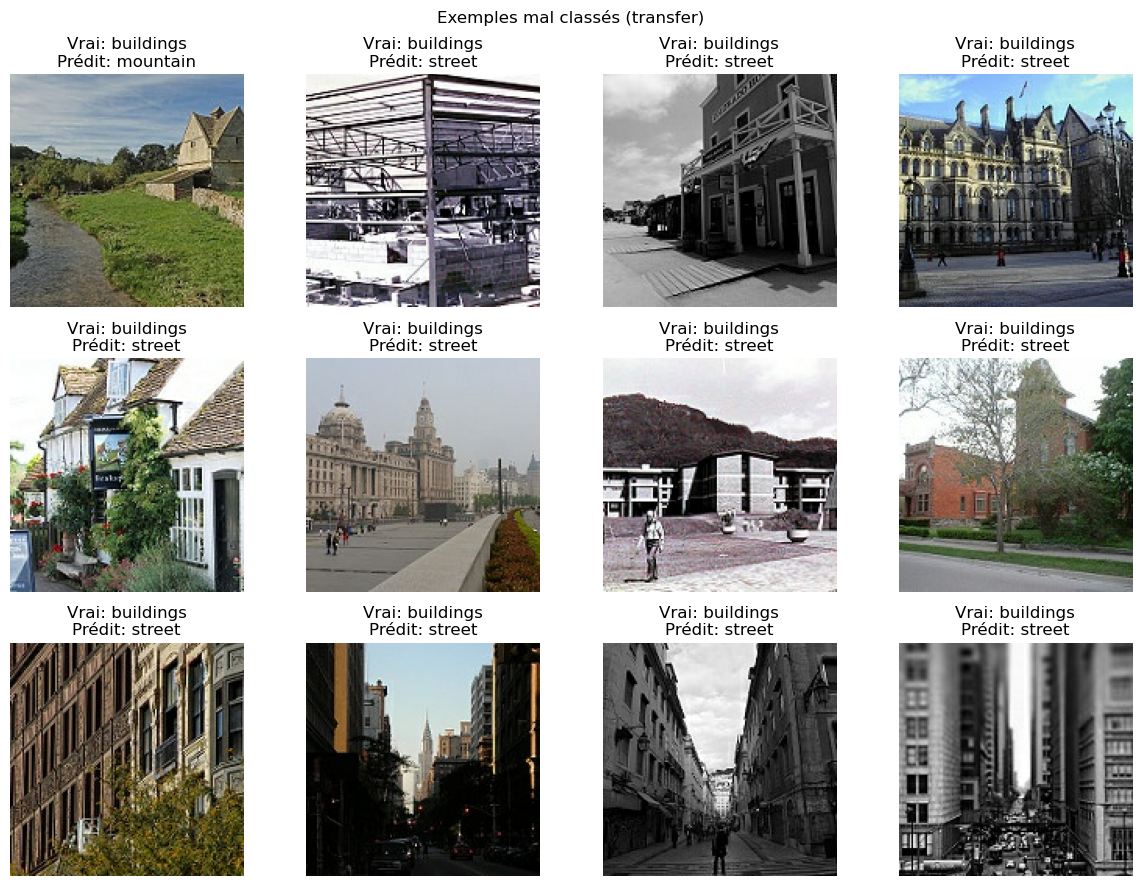

In [11]:

# Exemple d'analyse d'erreurs (pour le modèle 'transfer' par défaut)
mis = []
for batch_imgs, batch_labels in val_ds.take(20):  # sous-échantillon pour la démo
    probs = transfer.predict(batch_imgs, verbose=0)
    y_p = np.argmax(probs, axis=1)
    y_t = np.argmax(batch_labels.numpy(), axis=1)
    for i in range(len(y_t)):
        if y_p[i] != y_t[i]:
            mis.append((batch_imgs[i].numpy().astype("uint8"), y_t[i], y_p[i]))
            if len(mis) >= 12: break
    if len(mis) >= 12: break

if mis:
    rows, cols = 3, 4
    plt.figure(figsize=(cols*3, rows*3))
    for i, (img, t, p) in enumerate(mis[:rows*cols]):
        plt.subplot(rows, cols, i+1)
        plt.imshow(img); plt.axis("off")
        plt.title(f"Vrai: {class_names[t]}\nPrédit: {class_names[p]}")
    plt.suptitle("Exemples mal classés (transfer)")
    plt.tight_layout(); plt.show()
else:
    print("Pas assez d'exemples mal classés dans l'échantillon affiché.")


Bien qu'il y a une nette amélioration par rapport au modèle baseline, celui-ci confond encore souvent la classe *buildings* avec *street*, car les deux partagent un contexte visuel urbain très proche.  
Ces erreurs montrent que le réseau se base parfois davantage sur l’environnement global (rue, alignement d’immeubles) que sur le bâtiment lui-même.  



## 11) Conclusion & pistes d’amélioration

Notre modèle **baseline CNN** atteint ~81% d’accuracy, tandis que le modèle en **transfer learning** (MobileNetV2) améliore nettement les performances à ~91%.  
Les principales erreurs concernent surtout les confusions entre **glacier/mountain** et **buildings/street**, dues à leur forte similarité visuelle.  

Pour aller plus loin, plusieurs pistes sont envisageables :  
- enrichir l’**augmentation de données** (contraste, luminosité, rotations aléatoires),  
- utiliser des **class weights** en cas de déséquilibre,  
- tester le **fine-tuning partiel** de MobileNetV2 avec un petit learning rate (≈1e-5),  
- explorer d’autres architectures (**EfficientNet, ResNet50**) et optimiser les hyperparamètres,  
- nettoyer les données bruitées (images mal étiquetées).  
